# Python surprise で作る らくらく「レコメンドエンジン」（その５） – Streamlitで作る簡易「レコメンドWebアプリ」 –

url: https://www.salesanalytics.co.jp/datascience/datascience184/

    協調フィルタリングやSVDなどの鉄板の「推薦システム（レコメンドエンジン）」であれば、PythonのSurpriseライブラリで簡単に作れます。
    このライブラリは推薦アルゴリズムの学習と予測を簡単に行うことができます。
    
    レコメンドエンジンを使ったビジネス活用を考えると……
    ・何らかのシステムに組み込む
    ・ほぼ同じことを手作業で実施する

    ほぼ同じことを手作業で実施するとは……
    ・いつも決まった入力データで、
    ・いつもと同じ処理、
    ・そしていつもと同じアウトプットである

    そこで登場するのが、レコメンドWebアプリです。

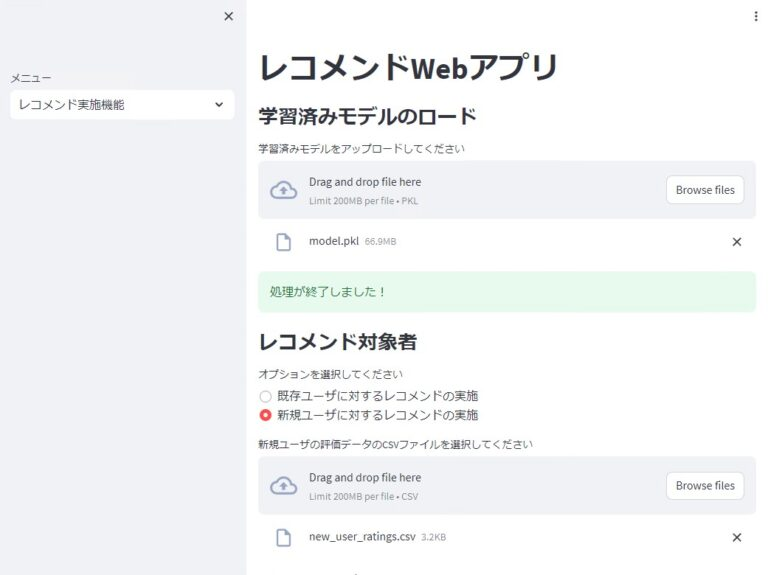

    ということで今回は、後者の「学習済みのレコメンドエンジンを使い新規ユーザに対しレコメンドをする方法」についてお話しします。

    その前に、レコメンドエンジンのコールドスタート問題に軽く触れます。

    見た目に強く拘るわけでなければ、StreamlitというPythonライブラリーで、簡易的なWebアプリを作ることができます。

    url: https://streamlit.io/

    ということで、今回はStreamlitで作る簡易「レコメンドWebアプリ」 を作っていきます。
    ちなみに、ローカルで動くWebアプリを作っていきます。
    Streamlitで作るWebアプリの簡単な説明を、以下の記事で実施しているので、興味のある方はご一読ください。

    url: https://www.salesanalytics.co.jp/datascience/datascience017/

## 今回作る簡易アプリ
    今回作る簡易アプリは……
    ・レコメンドエンジン学習機能
    ・レコメンド実機機能

    ……の2つの機能を持ち、レコメンド実施対象ユーザは……
    ・既存ユーザ（学習データに登場するユーザ）
    ・新規ユーザ（学習データに登場しないユーザ）

    ……です。

    推薦アルゴリズムはSVDで、ハイパーパラメータチューニングするかどうかを、選択できるようにしています。

    そして、学習したレコメンドエンジンや、レコメンド結果などは保存できるようにしています。

    長々と話しましたが、要は前回の記事の内容をもとにしたものです。

    url: https://www.salesanalytics.co.jp/datascience/datascience183/

    前回の記事の内容を、StreamlitでWebアプリ化した、という感じです。

## コード構成の簡易説明
    簡単にコード構成の説明をします。

    幾つかのパーツ（関数など）に分けてコーディングしています。

    main関数が名前の通りアプリの主要部で、この関数からレコメンドエンジンを学習するためのrecommend_engine_learning関数と、レコメンドを実施するrecommend_execution関数を呼び出して使います。

    他の関数は、recommend_engine_learning関数とrecommend_execution関数の中で使う関数です。

    では、各パーツ（関数など）の解説をします。

    インポート部: 必要なライブラリやモジュールをインポートしています。
    main関数: アプリケーションの主要な流れを制御します。
    Streamlitを使ってサイドバーに選択ボックスを表示し、選ばれた機能に基づいてrecommend_engine_learning または recommend_execution 関数を呼び出します。

    load_data関数: ユーザからの入力としてデータソース（CSVファイルまたはサンプルデータml-100k）を受け取り、対応するデータセットをロードして返します。

    hyperparameter_tuning関数: グリッドサーチを用いてハイパーパラメータチューニングを行い、最適なパラメータを返します。

    train_and_save_model関数: SVDアルゴリズムを使用して、レコメンドエンジンを学習し、学習済みのモデルと予測を指定されたファイルに保存します。

    recommend_engine_learning関数: ユーザにデータのロード方法を選択させ、選択された方法に応じてモデルの学習と保存を行います。

    recommend_execution関数: 学習済みのモデルをロードし、既存ユーザまたは新規ユーザ向けのレコメンドを実施します。

    load_trained_model関数: ユーザからアップロードされた学習済みモデルをロードして返します。

    recommend_existing_users関数: 既存ユーザ向けの上位Nのレコメンドを取得して表示します。

    recommend_new_users関数: 新規ユーザ向けのレコメンドを生成し、結果を表示します。

    get_top_n関数: 与えられた予測結果から各ユーザの上位Nのアイテムを取得します。
    最後の行にif __name__ == "__main__":を入れています。このスクリプトが直接実行された場合に、main関数を呼び出すためのものです。

    このアプリケーションを利用すると、ユーザは自分のデータでレコメンドエンジンを学習させたり、既存の学習済みモデルを用いてレコメンドを実施することができます。

## コード（app_rec.py）
    以下、今ざっくり説明したPythonコードの本体です。

In [1]:
pip install scikit-surprise

In [3]:
pip install streamlit

In [4]:
import streamlit as st
import pandas as pd
from surprise import SVD, Dataset, dump, Reader
from surprise.model_selection import GridSearchCV
from collections import defaultdict
import os

def main():
    # StreamlitのUI設定
    st.title("レコメンドWebアプリ")
    menu = ["レコメンドエンジン学習機能", "レコメンド実施機能"]
    choice = st.sidebar.selectbox("メニュー", menu)
    # ユーザーの選択に応じて機能を切り替え
    if choice == "レコメンドエンジン学習機能":
        recommend_engine_learning()
    else:
        recommend_execution()

def load_data():
    # データのロード機能
    data_source = st.radio(
        "データソースの選択",
        ["CSVファイル","サンプルデータ(ml-100k)"]
    )
    if data_source == "サンプルデータ(ml-100k)":
        return Dataset.load_builtin('ml-100k')

    uploaded_file = st.file_uploader(
        "CSVファイルを選択してください",
        type="csv"
    )
    if uploaded_file:
        df = pd.read_csv(uploaded_file)
        reader = Reader(rating_scale=(1, 5))
        return Dataset.load_from_df(
            df[["user_id", "item_id", "rating"]],
            reader
        )

def hyperparameter_tuning(data,cv_value):
    # ハイパーパラメータのチューニング機能
    param_grid = {
        'n_epochs': [5, 10, 20, 50],
        'lr_all': [0.002, 0.005, 0.01],
        'reg_all': [0.02, 0.1, 0.2, 0.4, 0.6],
        'n_factors': [50, 100, 200]
    }
    gs = GridSearchCV(
        SVD,
        param_grid,
        measures=['rmse', 'mae'],
        cv=cv_value
    )
    gs.fit(data)
    return gs.best_params

def train_and_save_model(data, cv_value=0):
    # モデルの学習と保存機能
    save_path = st.text_input(
        "保存するファイル名を入力してください",
        "model.pkl"
    )

    if st.button("学習&amp;保存"):
        with st.spinner("学習中..."):
            if cv_value>1:
                best_params = hyperparameter_tuning(data,cv_value)
                algo = SVD(**best_params['rmse'])
            else:
                algo = SVD()
            trainset = data.build_full_trainset()
            algo.fit(trainset)
            testset = trainset.build_anti_testset()
            predictions = algo.test(testset)
            dump.dump(save_path, predictions=predictions, algo=algo)
            st.success(f"モデルを {save_path} として保存しました！")

def recommend_engine_learning():
    # レコメンドエンジンの学習機能
    st.subheader("学習データのロード")
    data = load_data()
    if data:
        st.subheader("モデルの学習")
        tuning_choice = st.radio(
            "ハイパーパラメータチューニングの選択",
            ["ハイパーパラメータチューニングを実施する",
             "ハイパーパラメータチューニングを実施しない"]
        )
        if tuning_choice == "ハイパーパラメータチューニングを実施する":
            cv_value = st.slider(
                "CVの回数を選択してください",
                min_value=2, max_value=10, value=2, step=1
            )
            train_and_save_model(data, cv_value)
        else:
            train_and_save_model(data, 0)

def recommend_execution():
    # レコメンドの実施機能
    st.subheader("学習済みモデルのロード")
    predictions, loaded_algo = load_trained_model()
    st.subheader("レコメンド対象者")
    sub_menu = [
        "既存ユーザに対するレコメンドの実施",
        "新規ユーザに対するレコメンドの実施"
    ]
    choice = st.radio("オプションを選択してください", sub_menu)
    if loaded_algo:
        if choice == "既存ユーザに対するレコメンドの実施":
            recommend_existing_users(predictions, loaded_algo)
        else:
            recommend_new_users(loaded_algo)

def load_trained_model():
    # 学習済みモデルのロード機能
    uploaded_file = st.file_uploader(
        "学習済みモデルをアップロードしてください",
        type=["pkl"]
    )
    if uploaded_file:
        with st.spinner("処理中..."):
            with open("temp_model.pkl", "wb") as f:
                f.write(uploaded_file.read())
            predictions, loaded_algo = dump.load("temp_model.pkl")
            st.success("処理が終了しました！")
            return predictions, loaded_algo
    return None, None

def recommend_existing_users(predictions, loaded_algo):
    # 既存ユーザへのレコメンド機能
    st.subheader("既存ユーザへのレコメンド")
    with st.spinner("既存ユーザに対するレコメンド実施中..."):
        top_n_df = get_top_n(predictions, n=10)
        st.dataframe(top_n_df, width=600, height=400)
    save_filename = st.text_input(
        "保存するCSVファイル名を入力してください",
        "existing_user_recommendations.csv"
    )
    if st.button("結果をCSVファイルとして保存"):
        top_n_df.to_csv(save_filename, index=False)
        st.success(f"結果を {save_filename} として保存しました！")

def recommend_new_users(loaded_algo):
    # 新規ユーザのデータをアップロード
    uploaded_file = st.file_uploader(
        "新規ユーザの評価データのCSVファイルを選択してください",
        type="csv"
    )
    if uploaded_file:
        # アップロードされたファイルをデータフレームとして読み込む
        new_user_ratings = pd.read_csv(uploaded_file)

        # アルゴリズムから訓練データセットを取得
        trainset = loaded_algo.trainset
        unique_users = new_user_ratings['user_id'].unique()
        recommendations = []
        # サブヘッダの表示
        st.subheader("新規ユーザへのレコメンド")
        # 新規ユーザに対するレコメンドを実施
        with st.spinner("新規ユーザに対するレコメンド実施中..."):
            for user in unique_users:
                user_ratings = new_user_ratings[new_user_ratings['user_id'] == user]
                rated_items = user_ratings['item_id'].values.tolist()
                preds = []
                for iid in trainset.all_items():
                    # まだ評価されていないアイテムに対する予測を取得
                    if trainset.to_raw_iid(iid) not in rated_items:
                        preds.append(
                            (user, trainset.to_raw_iid(iid),
                             loaded_algo.predict(user, trainset.to_raw_iid(iid)).est)
                        )
                # 予測値の高い順にソート
                preds.sort(key=lambda x: x[2], reverse=True)
                recommendations.append(
                    pd.DataFrame(preds[:10],
                                 columns=['user_id', 'item_id', 'rating'])
                )
            # レコメンド結果の表示
            recommendations = pd.concat(recommendations)
            st.dataframe(recommendations, width=600, height=400)
            # レコメンド結果をCSVとして保存
            save_filename = st.text_input(
                "保存するCSVファイル名を入力してください",
                "new_user_recommendations.csv"
            )
            if st.button("結果をCSVファイルとして保存"):
                recommendations.to_csv(save_filename, index=False)
                st.success(f"結果を {save_filename} として保存しました！")

def get_top_n(predictions, n=10):
    # 予測結果から上位nのアイテムを取得する関数
    rows = []
    user_ratings = defaultdict(list)

    for uid, iid, true_r, est, _ in predictions:
        user_ratings[uid].append((iid, est))

    for uid, ratings in user_ratings.items():
        # 予測の高い順にソート
        ratings.sort(key=lambda x: x[1], reverse=True)
        top_ratings = ratings[:n]
        for iid, est in top_ratings:
            rows.append([uid, iid, est])

    return pd.DataFrame(rows, columns=['User', 'Item', 'Estimate'])

if __name__ == "__main__":
    # メイン関数の実行
    main()

    このPythonコードに、何かしら名前（例えば「app_rec.py」）をつけて保存してください。
    このPythonファイルをターミナル（Anaconda Prompt や PowerShell など）から呼び出してWebアプリを立ち上げます。

    このファイルは以下からダウンロードできます。

    app_rec.py
    https://www.salesanalytics.co.jp/lq2s

## 実行例
    今紹介したPythonファイルをターミナル（Anaconda Prompt や PowerShell など）から呼び出します。

    以下、コードです。

    streamlit run app_rec.py

    左のサイドパネルで以下の機能を選びます。
    ・レコメンドエンジン学習機能
    ・レコメンド実機機能
    メインパネルで、サイドパネルで選択した機能に応じてできることが変わってきます。

    レコメンドエンジン機能
    先ず、レコメンドエンジン機能で前回までと同じ映画のサンプルデータ（ml-100k）を使い、モデルを学習し保存（model.pkl）します。

    今回は、ハイパーパラメータのチューニングを行いません。

    以下、実行例です。

    ※サイトで要確認

## レコメンド実施機能
    次に、レコメンド実施機能で学習したモデルを読み込み、既存ユーザ（学習データに存在するユーザ）と新規ユーザ（学習データに存在しないユーザ）に対しレコメンドのための評価を実施します。Top10を出力しています。

    新規ユーザの評価データは、前回作成したものです。以下からダウンロードできます。

    新規ユーザの評価データ
    https://www.salesanalytics.co.jp/0ibs

    以下、実行例です。

    ※サイトで要確認

## まとめ
    今回はStreamlitで作る簡易「レコメンドWebアプリ」 を作りました。

    Streamlitは、Pythonだけで簡単にWebアプリの作れるライブラリーというかフレームワークです。

    surpriseには、他にも色々な推薦アルゴリズムが実装されているので、興味ある方は、例えば他の推薦アルゴリズムで構築したり、推薦アルゴリズムを選択できるようにしたり、AutoML風に自動で最適な推薦アルゴリズムの選択とハイパーパラメータチューニングをするWebアプリなどを作ってみてはいかがでしょうか。

    さらに、別の機会に内容ベースのフィルタリング(Content-Based Filtering)や、Word2Vec（レコメンドエンジンの場合はItem2Vecとも呼ばれる）などによるレコメンドエンジンにも触れたいと思います。